In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "40X"
trainable_blocks = ["block3", "block4"]
irun = 2


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_40X-BREAKHIS-Dataset-60-10-30-VGGINet/2'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/40X/2'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 1077 files belonging to 2 classes.


Found 179 files belonging to 2 classes.


Found 539 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2085 - accuracy: 0.4844

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/9 [=====>........................] - ETA: 5s - loss: 7.9525 - accuracy: 0.5820

3/9 [=========>....................] - ETA: 8s - loss: 8.1168 - accuracy: 0.6198

4/9 [============>.................] - ETA: 7s - loss: 7.1054 - accuracy: 0.6562

5/9 [===============>..............] - ETA: 6s - loss: 6.5720 - accuracy: 0.6625

6/9 [===================>..........] - ETA: 4s - loss: 6.7453 - accuracy: 0.6406

7/9 [======================>.......] - ETA: 2s - loss: 6.2823 - accuracy: 0.6596

8/9 [=========================>....] - ETA: 1s - loss: 5.8317 - accuracy: 0.6807

9/9 [==============================] - ETA: 0s - loss: 5.6908 - accuracy: 0.6880

9/9 [==============================] - 24s 3s/step - loss: 5.6908 - accuracy: 0.6880 - val_loss: 7.3158 - val_accuracy: 0.8659


Epoch 2/100


1/9 [==>...........................] - ETA: 0s - loss: 2.5741 - accuracy: 0.8672

2/9 [=====>........................] - ETA: 13s - loss: 2.6955 - accuracy: 0.8516

3/9 [=========>....................] - ETA: 9s - loss: 3.2752 - accuracy: 0.8281 

4/9 [============>.................] - ETA: 9s - loss: 3.1344 - accuracy: 0.8398

5/9 [===============>..............] - ETA: 7s - loss: 3.0018 - accuracy: 0.8469

6/9 [===================>..........] - ETA: 4s - loss: 2.8976 - accuracy: 0.8464

7/9 [======================>.......] - ETA: 3s - loss: 2.8424 - accuracy: 0.8371

8/9 [=========================>....] - ETA: 1s - loss: 2.6419 - accuracy: 0.8447

9/9 [==============================] - ETA: 0s - loss: 2.6214 - accuracy: 0.8440

9/9 [==============================] - 15s 2s/step - loss: 2.6214 - accuracy: 0.8440 - val_loss: 4.5986 - val_accuracy: 0.8827


Epoch 3/100


1/9 [==>...........................] - ETA: 0s - loss: 1.8639 - accuracy: 0.8125

2/9 [=====>........................] - ETA: 13s - loss: 1.4886 - accuracy: 0.8672

3/9 [=========>....................] - ETA: 9s - loss: 1.3847 - accuracy: 0.8750 

4/9 [============>.................] - ETA: 9s - loss: 1.2423 - accuracy: 0.8848

5/9 [===============>..............] - ETA: 7s - loss: 1.3804 - accuracy: 0.8844

6/9 [===================>..........] - ETA: 5s - loss: 1.3103 - accuracy: 0.8880

7/9 [======================>.......] - ETA: 3s - loss: 1.3029 - accuracy: 0.8929

8/9 [=========================>....] - ETA: 1s - loss: 1.3806 - accuracy: 0.8877

9/9 [==============================] - ETA: 0s - loss: 1.4061 - accuracy: 0.8867

9/9 [==============================] - 16s 2s/step - loss: 1.4061 - accuracy: 0.8867 - val_loss: 7.3374 - val_accuracy: 0.8380


Epoch 4/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5392 - accuracy: 0.9062

2/9 [=====>........................] - ETA: 13s - loss: 1.0830 - accuracy: 0.8945

3/9 [=========>....................] - ETA: 9s - loss: 1.2374 - accuracy: 0.8932 

4/9 [============>.................] - ETA: 9s - loss: 1.2301 - accuracy: 0.8848

5/9 [===============>..............] - ETA: 7s - loss: 1.4662 - accuracy: 0.8750

6/9 [===================>..........] - ETA: 5s - loss: 1.4048 - accuracy: 0.8724

7/9 [======================>.......] - ETA: 3s - loss: 1.2974 - accuracy: 0.8772

8/9 [=========================>....] - ETA: 1s - loss: 1.3124 - accuracy: 0.8799

9/9 [==============================] - ETA: 0s - loss: 1.3275 - accuracy: 0.8802

9/9 [==============================] - 16s 2s/step - loss: 1.3275 - accuracy: 0.8802 - val_loss: 2.1297 - val_accuracy: 0.9050


Epoch 5/100


1/9 [==>...........................] - ETA: 0s - loss: 1.5850 - accuracy: 0.8984

2/9 [=====>........................] - ETA: 14s - loss: 1.4227 - accuracy: 0.8828

3/9 [=========>....................] - ETA: 9s - loss: 1.3148 - accuracy: 0.8932 

4/9 [============>.................] - ETA: 10s - loss: 1.2453 - accuracy: 0.9004

5/9 [===============>..............] - ETA: 7s - loss: 1.1067 - accuracy: 0.9109 

6/9 [===================>..........] - ETA: 5s - loss: 1.0635 - accuracy: 0.9141

7/9 [======================>.......] - ETA: 3s - loss: 1.0403 - accuracy: 0.9118

8/9 [=========================>....] - ETA: 1s - loss: 1.0151 - accuracy: 0.9141

9/9 [==============================] - ETA: 0s - loss: 0.9840 - accuracy: 0.9136

9/9 [==============================] - 16s 2s/step - loss: 0.9840 - accuracy: 0.9136 - val_loss: 1.8768 - val_accuracy: 0.8827


Epoch 6/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5790 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 3s - loss: 0.6047 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 7s - loss: 0.6672 - accuracy: 0.9297

4/9 [============>.................] - ETA: 6s - loss: 0.6635 - accuracy: 0.9316

5/9 [===============>..............] - ETA: 6s - loss: 0.7393 - accuracy: 0.9187

6/9 [===================>..........] - ETA: 4s - loss: 0.7199 - accuracy: 0.9154

7/9 [======================>.......] - ETA: 2s - loss: 0.7841 - accuracy: 0.9085

8/9 [=========================>....] - ETA: 1s - loss: 0.8248 - accuracy: 0.9062

9/9 [==============================] - ETA: 0s - loss: 0.8550 - accuracy: 0.9062

9/9 [==============================] - 15s 2s/step - loss: 0.8550 - accuracy: 0.9062 - val_loss: 1.5340 - val_accuracy: 0.9162


Epoch 7/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7785 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 13s - loss: 0.7715 - accuracy: 0.9219

3/9 [=========>....................] - ETA: 9s - loss: 0.8665 - accuracy: 0.9036 

4/9 [============>.................] - ETA: 9s - loss: 0.7680 - accuracy: 0.9082

5/9 [===============>..............] - ETA: 6s - loss: 0.6767 - accuracy: 0.9156

6/9 [===================>..........] - ETA: 4s - loss: 0.7094 - accuracy: 0.9167

7/9 [======================>.......] - ETA: 2s - loss: 0.6983 - accuracy: 0.9185

8/9 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.9219

9/9 [==============================] - ETA: 0s - loss: 0.7187 - accuracy: 0.9201

9/9 [==============================] - 15s 2s/step - loss: 0.7187 - accuracy: 0.9201 - val_loss: 2.9863 - val_accuracy: 0.8939


Epoch 8/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4006 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 13s - loss: 0.5327 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 9s - loss: 0.5947 - accuracy: 0.9271 

4/9 [============>.................] - ETA: 9s - loss: 0.5938 - accuracy: 0.9297

5/9 [===============>..............] - ETA: 7s - loss: 0.6610 - accuracy: 0.9219

6/9 [===================>..........] - ETA: 5s - loss: 0.6920 - accuracy: 0.9232

7/9 [======================>.......] - ETA: 3s - loss: 0.7123 - accuracy: 0.9230

8/9 [=========================>....] - ETA: 1s - loss: 0.7271 - accuracy: 0.9238

9/9 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.9276

9/9 [==============================] - 16s 2s/step - loss: 0.6918 - accuracy: 0.9276 - val_loss: 1.2558 - val_accuracy: 0.9385


Epoch 9/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9193 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.6473 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 9s - loss: 0.6372 - accuracy: 0.9479 

4/9 [============>.................] - ETA: 9s - loss: 0.6390 - accuracy: 0.9473

5/9 [===============>..............] - ETA: 7s - loss: 0.6014 - accuracy: 0.9484

6/9 [===================>..........] - ETA: 5s - loss: 0.5847 - accuracy: 0.9479

7/9 [======================>.......] - ETA: 3s - loss: 0.5481 - accuracy: 0.9475

8/9 [=========================>....] - ETA: 1s - loss: 0.5832 - accuracy: 0.9434

9/9 [==============================] - ETA: 0s - loss: 0.5637 - accuracy: 0.9424

9/9 [==============================] - 16s 2s/step - loss: 0.5637 - accuracy: 0.9424 - val_loss: 1.4406 - val_accuracy: 0.9218


Epoch 10/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7006 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 12s - loss: 0.5369 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 9s - loss: 0.4548 - accuracy: 0.9531 

4/9 [============>.................] - ETA: 10s - loss: 0.6721 - accuracy: 0.9414

5/9 [===============>..............] - ETA: 7s - loss: 0.6531 - accuracy: 0.9406 

6/9 [===================>..........] - ETA: 5s - loss: 0.7000 - accuracy: 0.9323

7/9 [======================>.......] - ETA: 3s - loss: 0.6548 - accuracy: 0.9375

8/9 [=========================>....] - ETA: 1s - loss: 0.6050 - accuracy: 0.9375

9/9 [==============================] - ETA: 0s - loss: 0.6219 - accuracy: 0.9350

9/9 [==============================] - 15s 2s/step - loss: 0.6219 - accuracy: 0.9350 - val_loss: 1.9639 - val_accuracy: 0.9050


Epoch 11/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1205 - accuracy: 0.9062

2/9 [=====>........................] - ETA: 3s - loss: 1.1356 - accuracy: 0.9023

3/9 [=========>....................] - ETA: 15s - loss: 0.9493 - accuracy: 0.9193

4/9 [============>.................] - ETA: 10s - loss: 0.9263 - accuracy: 0.9160

5/9 [===============>..............] - ETA: 7s - loss: 0.8375 - accuracy: 0.9219 

6/9 [===================>..........] - ETA: 5s - loss: 0.8268 - accuracy: 0.9167

7/9 [======================>.......] - ETA: 3s - loss: 0.8045 - accuracy: 0.9196

8/9 [=========================>....] - ETA: 1s - loss: 0.8040 - accuracy: 0.9180

9/9 [==============================] - ETA: 0s - loss: 0.7645 - accuracy: 0.9220

9/9 [==============================] - 16s 2s/step - loss: 0.7645 - accuracy: 0.9220 - val_loss: 1.2551 - val_accuracy: 0.9330


Epoch 12/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5768 - accuracy: 0.9141

2/9 [=====>........................] - ETA: 13s - loss: 0.5043 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 9s - loss: 0.5302 - accuracy: 0.9297 

4/9 [============>.................] - ETA: 9s - loss: 0.7185 - accuracy: 0.9277

5/9 [===============>..............] - ETA: 7s - loss: 0.6111 - accuracy: 0.9328

6/9 [===================>..........] - ETA: 5s - loss: 0.6279 - accuracy: 0.9323

7/9 [======================>.......] - ETA: 3s - loss: 0.6028 - accuracy: 0.9353

8/9 [=========================>....] - ETA: 1s - loss: 0.6556 - accuracy: 0.9297

9/9 [==============================] - ETA: 0s - loss: 0.6472 - accuracy: 0.9304

9/9 [==============================] - 16s 2s/step - loss: 0.6472 - accuracy: 0.9304 - val_loss: 3.2329 - val_accuracy: 0.8939


Epoch 13/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0587 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.3765 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.3194 - accuracy: 0.9635 

4/9 [============>.................] - ETA: 9s - loss: 0.4025 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.4622 - accuracy: 0.9516

6/9 [===================>..........] - ETA: 5s - loss: 0.5324 - accuracy: 0.9492

7/9 [======================>.......] - ETA: 3s - loss: 0.5396 - accuracy: 0.9498

8/9 [=========================>....] - ETA: 1s - loss: 0.5278 - accuracy: 0.9502

9/9 [==============================] - ETA: 0s - loss: 0.5882 - accuracy: 0.9452

9/9 [==============================] - 16s 2s/step - loss: 0.5882 - accuracy: 0.9452 - val_loss: 1.0078 - val_accuracy: 0.9385


Epoch 14/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8698 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 11s - loss: 0.7048 - accuracy: 0.9219

3/9 [=========>....................] - ETA: 8s - loss: 0.6160 - accuracy: 0.9323 

4/9 [============>.................] - ETA: 9s - loss: 0.6127 - accuracy: 0.9316

5/9 [===============>..............] - ETA: 6s - loss: 0.5357 - accuracy: 0.9391

6/9 [===================>..........] - ETA: 4s - loss: 0.6369 - accuracy: 0.9323

7/9 [======================>.......] - ETA: 2s - loss: 0.6592 - accuracy: 0.9330

8/9 [=========================>....] - ETA: 1s - loss: 0.6407 - accuracy: 0.9355

9/9 [==============================] - ETA: 0s - loss: 0.6092 - accuracy: 0.9387

9/9 [==============================] - 15s 2s/step - loss: 0.6092 - accuracy: 0.9387 - val_loss: 0.9688 - val_accuracy: 0.9162


Epoch 15/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8752 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 12s - loss: 0.7470 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 9s - loss: 0.8342 - accuracy: 0.9271 

4/9 [============>.................] - ETA: 7s - loss: 0.7544 - accuracy: 0.9336

5/9 [===============>..............] - ETA: 7s - loss: 0.6509 - accuracy: 0.9406

6/9 [===================>..........] - ETA: 5s - loss: 0.5729 - accuracy: 0.9479

7/9 [======================>.......] - ETA: 3s - loss: 0.5630 - accuracy: 0.9509

8/9 [=========================>....] - ETA: 1s - loss: 0.5803 - accuracy: 0.9512

9/9 [==============================] - ETA: 0s - loss: 0.5827 - accuracy: 0.9499

9/9 [==============================] - 15s 2s/step - loss: 0.5827 - accuracy: 0.9499 - val_loss: 1.7811 - val_accuracy: 0.9274


Epoch 16/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6402 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.5213 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.5865 - accuracy: 0.9557 

4/9 [============>.................] - ETA: 9s - loss: 0.4941 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.4574 - accuracy: 0.9641

6/9 [===================>..........] - ETA: 5s - loss: 0.4992 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 3s - loss: 0.5175 - accuracy: 0.9587

8/9 [=========================>....] - ETA: 1s - loss: 0.5284 - accuracy: 0.9570

9/9 [==============================] - ETA: 0s - loss: 0.5366 - accuracy: 0.9564

9/9 [==============================] - 16s 2s/step - loss: 0.5366 - accuracy: 0.9564 - val_loss: 2.4761 - val_accuracy: 0.9162


Epoch 17/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5164 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.6606 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 10s - loss: 0.5659 - accuracy: 0.9453

4/9 [============>.................] - ETA: 9s - loss: 0.6400 - accuracy: 0.9414 

5/9 [===============>..............] - ETA: 7s - loss: 0.5795 - accuracy: 0.9453

6/9 [===================>..........] - ETA: 5s - loss: 0.5330 - accuracy: 0.9492

7/9 [======================>.......] - ETA: 3s - loss: 0.5046 - accuracy: 0.9475

8/9 [=========================>....] - ETA: 1s - loss: 0.5012 - accuracy: 0.9463

9/9 [==============================] - ETA: 0s - loss: 0.5177 - accuracy: 0.9452

9/9 [==============================] - 16s 2s/step - loss: 0.5177 - accuracy: 0.9452 - val_loss: 2.1925 - val_accuracy: 0.9162


Epoch 18/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2367 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 22s - loss: 0.4373 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 20s - loss: 0.3834 - accuracy: 0.9583

4/9 [============>.................] - ETA: 14s - loss: 0.3220 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 9s - loss: 0.3712 - accuracy: 0.9516 

6/9 [===================>..........] - ETA: 6s - loss: 0.4146 - accuracy: 0.9531

7/9 [======================>.......] - ETA: 4s - loss: 0.4359 - accuracy: 0.9542

8/9 [=========================>....] - ETA: 1s - loss: 0.5069 - accuracy: 0.9521

9/9 [==============================] - ETA: 0s - loss: 0.5027 - accuracy: 0.9526

9/9 [==============================] - 19s 2s/step - loss: 0.5027 - accuracy: 0.9526 - val_loss: 1.2157 - val_accuracy: 0.9274


Epoch 19/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1960 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 12s - loss: 0.2102 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.2021 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 10s - loss: 0.1791 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.1492 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.1900 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.1911 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.2077 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.2294 - accuracy: 0.9684

9/9 [==============================] - 15s 2s/step - loss: 0.2294 - accuracy: 0.9684 - val_loss: 1.1657 - val_accuracy: 0.9106


Epoch 20/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5282 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.3508 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.3048 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 9s - loss: 0.3502 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.5401 - accuracy: 0.9578

6/9 [===================>..........] - ETA: 5s - loss: 0.4761 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.4351 - accuracy: 0.9609

8/9 [=========================>....] - ETA: 1s - loss: 0.4312 - accuracy: 0.9619

9/9 [==============================] - ETA: 0s - loss: 0.4100 - accuracy: 0.9638

9/9 [==============================] - 16s 2s/step - loss: 0.4100 - accuracy: 0.9638 - val_loss: 1.3318 - val_accuracy: 0.9385


Epoch 21/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5672 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.3761 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 9s - loss: 0.6412 - accuracy: 0.9453 

4/9 [============>.................] - ETA: 9s - loss: 0.5352 - accuracy: 0.9531

5/9 [===============>..............] - ETA: 7s - loss: 0.5061 - accuracy: 0.9531

6/9 [===================>..........] - ETA: 4s - loss: 0.4505 - accuracy: 0.9570

7/9 [======================>.......] - ETA: 3s - loss: 0.4343 - accuracy: 0.9587

8/9 [=========================>....] - ETA: 1s - loss: 0.4571 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.4474 - accuracy: 0.9564

9/9 [==============================] - 15s 2s/step - loss: 0.4474 - accuracy: 0.9564 - val_loss: 1.1307 - val_accuracy: 0.9385


Epoch 22/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4183 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 12s - loss: 0.2834 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.3591 - accuracy: 0.9557 

4/9 [============>.................] - ETA: 9s - loss: 0.4071 - accuracy: 0.9590

5/9 [===============>..............] - ETA: 6s - loss: 0.3665 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 4s - loss: 0.3453 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 2s - loss: 0.3532 - accuracy: 0.9609

8/9 [=========================>....] - ETA: 1s - loss: 0.3521 - accuracy: 0.9619

9/9 [==============================] - ETA: 0s - loss: 0.3363 - accuracy: 0.9629

9/9 [==============================] - 15s 2s/step - loss: 0.3363 - accuracy: 0.9629 - val_loss: 3.3372 - val_accuracy: 0.9106


Epoch 23/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3580 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.2997 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.2872 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 9s - loss: 0.3260 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 6s - loss: 0.3988 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 4s - loss: 0.4164 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.3716 - accuracy: 0.9632

8/9 [=========================>....] - ETA: 1s - loss: 0.3420 - accuracy: 0.9639

9/9 [==============================] - ETA: 0s - loss: 0.3520 - accuracy: 0.9629

9/9 [==============================] - 15s 2s/step - loss: 0.3520 - accuracy: 0.9629 - val_loss: 1.1950 - val_accuracy: 0.9385


Epoch 24/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4105 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.4082 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 4s - loss: 0.5640 - accuracy: 0.9688

4/9 [============>.................] - ETA: 5s - loss: 0.4581 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 5s - loss: 0.4556 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 3s - loss: 0.5344 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 2s - loss: 0.5188 - accuracy: 0.9643

8/9 [=========================>....] - ETA: 1s - loss: 0.4668 - accuracy: 0.9658

9/9 [==============================] - ETA: 0s - loss: 0.5437 - accuracy: 0.9610

9/9 [==============================] - 13s 1s/step - loss: 0.5437 - accuracy: 0.9610 - val_loss: 1.3200 - val_accuracy: 0.9441


Epoch 25/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2147 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.2201 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.2914 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 9s - loss: 0.3040 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.2721 - accuracy: 0.9625

6/9 [===================>..........] - ETA: 5s - loss: 0.2320 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.2495 - accuracy: 0.9654

8/9 [=========================>....] - ETA: 1s - loss: 0.2519 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.2893 - accuracy: 0.9638

9/9 [==============================] - 16s 2s/step - loss: 0.2893 - accuracy: 0.9638 - val_loss: 0.8593 - val_accuracy: 0.9665


Epoch 26/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1955 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 5s - loss: 0.3136 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.2893 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.5669 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.5113 - accuracy: 0.9656 

6/9 [===================>..........] - ETA: 5s - loss: 0.6930 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 3s - loss: 0.7206 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.6533 - accuracy: 0.9609

9/9 [==============================] - ETA: 0s - loss: 0.6784 - accuracy: 0.9601

9/9 [==============================] - 16s 2s/step - loss: 0.6784 - accuracy: 0.9601 - val_loss: 0.6104 - val_accuracy: 0.9665


Epoch 27/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2799 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.6128 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.4757 - accuracy: 0.9583 

4/9 [============>.................] - ETA: 9s - loss: 0.6050 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.5708 - accuracy: 0.9578

6/9 [===================>..........] - ETA: 5s - loss: 0.5898 - accuracy: 0.9544

7/9 [======================>.......] - ETA: 3s - loss: 0.5204 - accuracy: 0.9587

8/9 [=========================>....] - ETA: 1s - loss: 0.5551 - accuracy: 0.9561

9/9 [==============================] - ETA: 0s - loss: 0.5542 - accuracy: 0.9536

9/9 [==============================] - 16s 2s/step - loss: 0.5542 - accuracy: 0.9536 - val_loss: 0.3919 - val_accuracy: 0.9609


Epoch 28/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4040 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.4324 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.6178 - accuracy: 0.9557 

4/9 [============>.................] - ETA: 9s - loss: 0.5554 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.5699 - accuracy: 0.9578

6/9 [===================>..........] - ETA: 5s - loss: 0.6398 - accuracy: 0.9531

7/9 [======================>.......] - ETA: 3s - loss: 0.5563 - accuracy: 0.9565

8/9 [=========================>....] - ETA: 1s - loss: 0.5164 - accuracy: 0.9580

9/9 [==============================] - ETA: 0s - loss: 0.5101 - accuracy: 0.9582

9/9 [==============================] - 16s 2s/step - loss: 0.5101 - accuracy: 0.9582 - val_loss: 2.4796 - val_accuracy: 0.9274


Epoch 29/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3140 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 16s - loss: 0.7610 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 14s - loss: 0.7418 - accuracy: 0.9609

4/9 [============>.................] - ETA: 10s - loss: 0.6624 - accuracy: 0.9590

5/9 [===============>..............] - ETA: 7s - loss: 0.6332 - accuracy: 0.9594 

6/9 [===================>..........] - ETA: 5s - loss: 0.6613 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.5876 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.5565 - accuracy: 0.9600

9/9 [==============================] - ETA: 0s - loss: 0.5351 - accuracy: 0.9601

9/9 [==============================] - 16s 2s/step - loss: 0.5351 - accuracy: 0.9601 - val_loss: 2.3718 - val_accuracy: 0.9274


Epoch 30/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3065 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 12s - loss: 0.2817 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.2396 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 9s - loss: 0.2164 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.2972 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 5s - loss: 0.3127 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.3721 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.3988 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.3960 - accuracy: 0.9694

9/9 [==============================] - 16s 2s/step - loss: 0.3960 - accuracy: 0.9694 - val_loss: 1.8932 - val_accuracy: 0.9274


Epoch 31/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2477 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 3s - loss: 0.6574 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 3s - loss: 0.5876 - accuracy: 0.9609

4/9 [============>.................] - ETA: 5s - loss: 0.4698 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 5s - loss: 0.4664 - accuracy: 0.9641

6/9 [===================>..........] - ETA: 3s - loss: 0.6687 - accuracy: 0.9544

7/9 [======================>.......] - ETA: 2s - loss: 0.6617 - accuracy: 0.9542

8/9 [=========================>....] - ETA: 1s - loss: 0.6691 - accuracy: 0.9541

9/9 [==============================] - ETA: 0s - loss: 0.6498 - accuracy: 0.9545

9/9 [==============================] - 13s 1s/step - loss: 0.6498 - accuracy: 0.9545 - val_loss: 1.5729 - val_accuracy: 0.9385


Epoch 32/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3630 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.2012 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.2495 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 10s - loss: 0.2492 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.6079 - accuracy: 0.9625 

6/9 [===================>..........] - ETA: 5s - loss: 0.6177 - accuracy: 0.9609

7/9 [======================>.......] - ETA: 3s - loss: 0.5720 - accuracy: 0.9632

8/9 [=========================>....] - ETA: 1s - loss: 0.5582 - accuracy: 0.9619

9/9 [==============================] - ETA: 0s - loss: 0.5576 - accuracy: 0.9619

9/9 [==============================] - 16s 2s/step - loss: 0.5576 - accuracy: 0.9619 - val_loss: 1.3731 - val_accuracy: 0.9441


Epoch 33/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0912 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.1120 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.2206 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 9s - loss: 0.1875 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2639 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 5s - loss: 0.2212 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.1897 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.1966 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2231 - accuracy: 0.9749

9/9 [==============================] - 16s 2s/step - loss: 0.2231 - accuracy: 0.9749 - val_loss: 0.7904 - val_accuracy: 0.9553


Epoch 34/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0760 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.4652 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.3271 - accuracy: 0.9740

4/9 [============>.................] - ETA: 9s - loss: 0.3324 - accuracy: 0.9766 

5/9 [===============>..............] - ETA: 7s - loss: 0.3886 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 5s - loss: 0.3525 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.3274 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.3494 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.3433 - accuracy: 0.9712

9/9 [==============================] - 16s 2s/step - loss: 0.3433 - accuracy: 0.9712 - val_loss: 1.0973 - val_accuracy: 0.9497


Epoch 35/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5864 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.5509 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.4464 - accuracy: 0.9661

4/9 [============>.................] - ETA: 9s - loss: 0.4568 - accuracy: 0.9668 

5/9 [===============>..............] - ETA: 7s - loss: 0.7254 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 4s - loss: 0.6644 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.7145 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.7492 - accuracy: 0.9609

9/9 [==============================] - ETA: 0s - loss: 0.7754 - accuracy: 0.9573

9/9 [==============================] - 15s 2s/step - loss: 0.7754 - accuracy: 0.9573 - val_loss: 1.3393 - val_accuracy: 0.9330


Epoch 36/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7064 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 3s - loss: 0.6012 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 3s - loss: 0.4009 - accuracy: 0.9714

4/9 [============>.................] - ETA: 5s - loss: 0.4747 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 4s - loss: 0.3798 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 3s - loss: 0.3173 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 2s - loss: 0.3376 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3341 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.3687 - accuracy: 0.9805

9/9 [==============================] - 12s 1s/step - loss: 0.3687 - accuracy: 0.9805 - val_loss: 1.2094 - val_accuracy: 0.9385


Epoch 37/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3520 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.3757 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.4478 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 9s - loss: 0.5209 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.4297 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 5s - loss: 0.3638 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.3587 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.5183 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.5120 - accuracy: 0.9712

9/9 [==============================] - 16s 2s/step - loss: 0.5120 - accuracy: 0.9712 - val_loss: 1.7749 - val_accuracy: 0.9330


Epoch 38/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3121 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.4498 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 3s - loss: 0.4376 - accuracy: 0.9714

4/9 [============>.................] - ETA: 5s - loss: 0.4115 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 5s - loss: 0.3655 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 3s - loss: 0.4156 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 2s - loss: 0.4306 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.4089 - accuracy: 0.9648

9/9 [==============================] - ETA: 0s - loss: 0.4441 - accuracy: 0.9629

9/9 [==============================] - 13s 1s/step - loss: 0.4441 - accuracy: 0.9629 - val_loss: 3.2408 - val_accuracy: 0.9050


Epoch 39/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2616 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.2952 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.2686 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 9s - loss: 0.3292 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 6s - loss: 0.2851 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 4s - loss: 0.3849 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.3316 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.3288 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.3463 - accuracy: 0.9740

9/9 [==============================] - 15s 2s/step - loss: 0.3463 - accuracy: 0.9740 - val_loss: 0.7912 - val_accuracy: 0.9553


Epoch 40/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5662 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.4100 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.2764 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 9s - loss: 0.2089 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 8s - loss: 0.2459 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 5s - loss: 0.2382 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3271 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.3269 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.3197 - accuracy: 0.9731

9/9 [==============================] - 16s 2s/step - loss: 0.3197 - accuracy: 0.9731 - val_loss: 0.9031 - val_accuracy: 0.9609


Epoch 41/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2929 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.3631 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.3523 - accuracy: 0.9688

4/9 [============>.................] - ETA: 9s - loss: 0.3872 - accuracy: 0.9648 

5/9 [===============>..............] - ETA: 7s - loss: 0.4575 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 4s - loss: 0.3834 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.3777 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.3374 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.3346 - accuracy: 0.9721

9/9 [==============================] - 15s 2s/step - loss: 0.3346 - accuracy: 0.9721 - val_loss: 0.6585 - val_accuracy: 0.9665


Epoch 42/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0931 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.4405 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.4258 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 9s - loss: 0.4239 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.3768 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 5s - loss: 0.3596 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.3229 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.2928 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0.9759

9/9 [==============================] - 16s 2s/step - loss: 0.2844 - accuracy: 0.9759 - val_loss: 1.1490 - val_accuracy: 0.9441


Epoch 43/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0523 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.0721 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.1485 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 10s - loss: 0.1494 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.1382 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2636 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2870 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3275 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3772 - accuracy: 0.9749

9/9 [==============================] - 16s 2s/step - loss: 0.3772 - accuracy: 0.9749 - val_loss: 1.5458 - val_accuracy: 0.9385


Epoch 44/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0079 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.1770 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 3s - loss: 0.3719 - accuracy: 0.9792

4/9 [============>.................] - ETA: 5s - loss: 0.3023 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 4s - loss: 0.2954 - accuracy: 0.9797

6/9 [===================>..........] - ETA: 3s - loss: 0.3164 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 2s - loss: 0.3860 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.3717 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.3538 - accuracy: 0.9731

9/9 [==============================] - 12s 1s/step - loss: 0.3538 - accuracy: 0.9731 - val_loss: 0.6660 - val_accuracy: 0.9609


Epoch 45/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3832 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.3625 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.2846 - accuracy: 0.9766

4/9 [============>.................] - ETA: 9s - loss: 0.2448 - accuracy: 0.9766 

5/9 [===============>..............] - ETA: 8s - loss: 0.3887 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 5s - loss: 0.3331 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2942 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2631 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2501 - accuracy: 0.9833

9/9 [==============================] - 17s 2s/step - loss: 0.2501 - accuracy: 0.9833 - val_loss: 0.5797 - val_accuracy: 0.9721


Epoch 46/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1042 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.2303 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 15s - loss: 0.2637 - accuracy: 0.9766

4/9 [============>.................] - ETA: 11s - loss: 0.2019 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.2851 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.2645 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2312 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2027 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.1927 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.1927 - accuracy: 0.9851 - val_loss: 0.8165 - val_accuracy: 0.9497


Epoch 47/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1776 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2606 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2798 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.3846 - accuracy: 0.9785 

5/9 [===============>..............] - ETA: 7s - loss: 0.3323 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 4s - loss: 0.3161 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2741 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2651 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2521 - accuracy: 0.9842

9/9 [==============================] - 15s 2s/step - loss: 0.2521 - accuracy: 0.9842 - val_loss: 0.8372 - val_accuracy: 0.9497


Epoch 48/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 13s - loss: 0.3112 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2425 - accuracy: 0.9818

4/9 [============>.................] - ETA: 9s - loss: 0.3866 - accuracy: 0.9785 

5/9 [===============>..............] - ETA: 7s - loss: 0.3948 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 5s - loss: 0.4390 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.4209 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.3803 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.3640 - accuracy: 0.9749

9/9 [==============================] - 16s 2s/step - loss: 0.3640 - accuracy: 0.9749 - val_loss: 1.2193 - val_accuracy: 0.9609


Epoch 49/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6684 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.3754 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.4892 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 9s - loss: 0.4121 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 6s - loss: 0.3418 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 4s - loss: 0.3256 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3516 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3367 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3420 - accuracy: 0.9777

9/9 [==============================] - 15s 2s/step - loss: 0.3420 - accuracy: 0.9777 - val_loss: 0.7089 - val_accuracy: 0.9777


Epoch 50/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2785 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.2588 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 9s - loss: 0.1733 - accuracy: 0.9948 

4/9 [============>.................] - ETA: 9s - loss: 0.3887 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.3667 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.4086 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.3681 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3221 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.3361 - accuracy: 0.9824

9/9 [==============================] - 16s 2s/step - loss: 0.3361 - accuracy: 0.9824 - val_loss: 0.8421 - val_accuracy: 0.9721


Epoch 51/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1480 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.2029 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 7s - loss: 0.3460 - accuracy: 0.9792

4/9 [============>.................] - ETA: 6s - loss: 0.2595 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 6s - loss: 0.2127 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 4s - loss: 0.1842 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 2s - loss: 0.2179 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2503 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2474 - accuracy: 0.9842

9/9 [==============================] - 14s 2s/step - loss: 0.2474 - accuracy: 0.9842 - val_loss: 0.9403 - val_accuracy: 0.9777


Epoch 52/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1924 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1525 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1418 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.2132 - accuracy: 0.9824 

5/9 [===============>..............] - ETA: 7s - loss: 0.3200 - accuracy: 0.9797

6/9 [===================>..........] - ETA: 5s - loss: 0.2743 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.3300 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.3060 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2991 - accuracy: 0.9786

9/9 [==============================] - 16s 2s/step - loss: 0.2991 - accuracy: 0.9786 - val_loss: 0.8094 - val_accuracy: 0.9721


Epoch 53/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0488 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.0245 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 15s - loss: 0.1866 - accuracy: 0.9792

4/9 [============>.................] - ETA: 13s - loss: 0.1399 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 9s - loss: 0.1308 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 6s - loss: 0.1170 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1275 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.1533 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.1460 - accuracy: 0.9851

9/9 [==============================] - 18s 2s/step - loss: 0.1460 - accuracy: 0.9851 - val_loss: 1.0363 - val_accuracy: 0.9609


Epoch 54/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4088 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.2283 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.2268 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 9s - loss: 0.2475 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.3095 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 5s - loss: 0.2762 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2543 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2675 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3297 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.3297 - accuracy: 0.9796 - val_loss: 1.0939 - val_accuracy: 0.9609


Epoch 55/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3033 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.1906 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.1358 - accuracy: 0.9870 

4/9 [============>.................] - ETA: 9s - loss: 0.1119 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.1241 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.1291 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.1476 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.1355 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.1416 - accuracy: 0.9842

9/9 [==============================] - 16s 2s/step - loss: 0.1416 - accuracy: 0.9842 - val_loss: 1.1366 - val_accuracy: 0.9665


Epoch 56/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1577 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 3s - loss: 0.0788 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 4s - loss: 0.0526 - accuracy: 0.9870

4/9 [============>.................] - ETA: 6s - loss: 0.0795 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 5s - loss: 0.1623 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 3s - loss: 0.1726 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 2s - loss: 0.1481 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.2002 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.1904 - accuracy: 0.9861

9/9 [==============================] - 13s 1s/step - loss: 0.1904 - accuracy: 0.9861 - val_loss: 0.9102 - val_accuracy: 0.9721


Epoch 57/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2150 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.2751 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.3233 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 9s - loss: 0.2425 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2850 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 5s - loss: 0.2914 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2797 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2568 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2442 - accuracy: 0.9833

9/9 [==============================] - 16s 2s/step - loss: 0.2442 - accuracy: 0.9833 - val_loss: 1.0207 - val_accuracy: 0.9721


Epoch 58/100


1/9 [==>...........................] - ETA: 0s - loss: 5.7414e-06 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0441 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 10s - loss: 0.0439 - accuracy: 0.9948

4/9 [============>.................] - ETA: 9s - loss: 0.1362 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 7s - loss: 0.1174 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 4s - loss: 0.0979 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1335 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1403 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1569 - accuracy: 0.9861

9/9 [==============================] - 15s 2s/step - loss: 0.1569 - accuracy: 0.9861 - val_loss: 1.4134 - val_accuracy: 0.9385


Epoch 59/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4603 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2770 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.1950 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.1754 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 7s - loss: 0.1534 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 5s - loss: 0.1278 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1303 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1347 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.9879

9/9 [==============================] - 16s 2s/step - loss: 0.1281 - accuracy: 0.9879 - val_loss: 1.1660 - val_accuracy: 0.9553


Epoch 60/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0586 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.2297 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.1536 - accuracy: 0.9896 

4/9 [============>.................] - ETA: 10s - loss: 0.2090 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.1673 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.2044 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2278 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2056 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.9842

9/9 [==============================] - 16s 2s/step - loss: 0.1975 - accuracy: 0.9842 - val_loss: 1.0153 - val_accuracy: 0.9665


Epoch 61/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2757 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.1786 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1709 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.1515 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 7s - loss: 0.1683 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 4s - loss: 0.1779 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.1525 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1964 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.9861

9/9 [==============================] - 15s 2s/step - loss: 0.1870 - accuracy: 0.9861 - val_loss: 1.6533 - val_accuracy: 0.9385


Epoch 62/100


1/9 [==>...........................] - ETA: 0s - loss: 1.3970e-08 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 13s - loss: 0.0529 - accuracy: 0.9922   

3/9 [=========>....................] - ETA: 9s - loss: 0.0921 - accuracy: 0.9896 

4/9 [============>.................] - ETA: 9s - loss: 0.1012 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.0810 - accuracy: 0.9891

6/9 [===================>..........] - ETA: 4s - loss: 0.0702 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.0783 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.0709 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.0674 - accuracy: 0.9898

9/9 [==============================] - 15s 2s/step - loss: 0.0674 - accuracy: 0.9898 - val_loss: 1.5176 - val_accuracy: 0.9497


Epoch 63/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2879e-06 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0233 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 10s - loss: 0.0379 - accuracy: 0.9922

4/9 [============>.................] - ETA: 9s - loss: 0.1600 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 7s - loss: 0.1954 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.1636 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1608 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.1518 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.1443 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.1443 - accuracy: 0.9851 - val_loss: 1.6853 - val_accuracy: 0.9385


Epoch 64/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5496 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.4400 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.3584 - accuracy: 0.9818 

4/9 [============>.................] - ETA: 9s - loss: 0.3290 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2833 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 4s - loss: 0.2494 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2138 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2011 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2050 - accuracy: 0.9842

9/9 [==============================] - 15s 2s/step - loss: 0.2050 - accuracy: 0.9842 - val_loss: 0.7556 - val_accuracy: 0.9609


Epoch 65/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1220 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.1075 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 9s - loss: 0.2016 - accuracy: 0.9870 

4/9 [============>.................] - ETA: 9s - loss: 0.1648 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1725 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 4s - loss: 0.1560 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1435 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1634 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1578 - accuracy: 0.9870

9/9 [==============================] - 15s 2s/step - loss: 0.1578 - accuracy: 0.9870 - val_loss: 1.4581 - val_accuracy: 0.9609


Epoch 66/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0750 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.4957 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 7s - loss: 0.3376 - accuracy: 0.9870

4/9 [============>.................] - ETA: 9s - loss: 0.3858 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.3606 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 5s - loss: 0.3080 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2660 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2380 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2307 - accuracy: 0.9824

9/9 [==============================] - 16s 2s/step - loss: 0.2307 - accuracy: 0.9824 - val_loss: 1.7467 - val_accuracy: 0.9553


Epoch 67/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1547 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.1451 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1443 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.1415 - accuracy: 0.9824 

5/9 [===============>..............] - ETA: 7s - loss: 0.1202 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.1405 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.1458 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.1657 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.1950 - accuracy: 0.9824

9/9 [==============================] - 16s 2s/step - loss: 0.1950 - accuracy: 0.9824 - val_loss: 2.5074 - val_accuracy: 0.9162


Epoch 68/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1346 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.0674 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1153 - accuracy: 0.9922

4/9 [============>.................] - ETA: 9s - loss: 0.1833 - accuracy: 0.9902 

5/9 [===============>..............] - ETA: 7s - loss: 0.1519 - accuracy: 0.9891

6/9 [===================>..........] - ETA: 4s - loss: 0.1418 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1215 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.2219 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2111 - accuracy: 0.9842

9/9 [==============================] - 15s 2s/step - loss: 0.2111 - accuracy: 0.9842 - val_loss: 1.0210 - val_accuracy: 0.9609


Epoch 69/100


1/9 [==>...........................] - ETA: 0s - loss: 5.0062e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 13s - loss: 0.1843 - accuracy: 0.9883   

3/9 [=========>....................] - ETA: 9s - loss: 0.1364 - accuracy: 0.9896 

4/9 [============>.................] - ETA: 10s - loss: 0.1295 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.1326 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.1348 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1255 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1566 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.9889

9/9 [==============================] - 16s 2s/step - loss: 0.1489 - accuracy: 0.9889 - val_loss: 1.0756 - val_accuracy: 0.9553


Epoch 70/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2872 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.5186 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.3460 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2595 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.2077 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.1936 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1660 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.1898 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.9870

9/9 [==============================] - 16s 2s/step - loss: 0.1870 - accuracy: 0.9870 - val_loss: 1.1548 - val_accuracy: 0.9665


Epoch 71/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3241 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.2069 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 15s - loss: 0.1380 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.1136 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.0924 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.0944 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.0809 - accuracy: 0.9922

8/9 [=========================>....] - ETA: 1s - loss: 0.0728 - accuracy: 0.9912

9/9 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9907

9/9 [==============================] - 16s 2s/step - loss: 0.0715 - accuracy: 0.9907 - val_loss: 1.9273 - val_accuracy: 0.9553


Epoch 72/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0088 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0473 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.0551 - accuracy: 0.9896

4/9 [============>.................] - ETA: 9s - loss: 0.0838 - accuracy: 0.9902 

5/9 [===============>..............] - ETA: 7s - loss: 0.0846 - accuracy: 0.9891

6/9 [===================>..........] - ETA: 4s - loss: 0.0716 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.0614 - accuracy: 0.9922

8/9 [=========================>....] - ETA: 1s - loss: 0.0935 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9898

9/9 [==============================] - 15s 2s/step - loss: 0.0889 - accuracy: 0.9898 - val_loss: 1.5156 - val_accuracy: 0.9609


Epoch 73/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0113 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.1468 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 3s - loss: 0.0979 - accuracy: 0.9948

4/9 [============>.................] - ETA: 5s - loss: 0.0912 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 4s - loss: 0.0803 - accuracy: 0.9906

6/9 [===================>..........] - ETA: 3s - loss: 0.0981 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 2s - loss: 0.1402 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1654 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.1708 - accuracy: 0.9851

9/9 [==============================] - 12s 1s/step - loss: 0.1708 - accuracy: 0.9851 - val_loss: 1.2552 - val_accuracy: 0.9721


Epoch 74/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2616 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.1599 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.3614 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 9s - loss: 0.2799 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2573 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.2824 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.3081 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3030 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.9814

9/9 [==============================] - 16s 2s/step - loss: 0.2881 - accuracy: 0.9814 - val_loss: 1.2490 - val_accuracy: 0.9721


Epoch 75/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2049 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.2258 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 15s - loss: 0.3525 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.3402 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2722 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.3202 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3016 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3056 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2906 - accuracy: 0.9824

9/9 [==============================] - 16s 2s/step - loss: 0.2906 - accuracy: 0.9824 - val_loss: 1.6912 - val_accuracy: 0.9497


Epoch 76/100


1/9 [==>...........................] - ETA: 0s - loss: 8.6935e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0112 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 10s - loss: 0.1946 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.1460 - accuracy: 0.9883 

5/9 [===============>..............] - ETA: 7s - loss: 0.1547 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 5s - loss: 0.2011 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2130 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.1864 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2385 - accuracy: 0.9842

9/9 [==============================] - 16s 2s/step - loss: 0.2385 - accuracy: 0.9842 - val_loss: 1.0863 - val_accuracy: 0.9553


Epoch 77/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2203 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2782 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1863 - accuracy: 0.9948

4/9 [============>.................] - ETA: 9s - loss: 0.1822 - accuracy: 0.9922 

5/9 [===============>..............] - ETA: 7s - loss: 0.1585 - accuracy: 0.9891

6/9 [===================>..........] - ETA: 4s - loss: 0.1321 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.1197 - accuracy: 0.9911

8/9 [=========================>....] - ETA: 1s - loss: 0.1254 - accuracy: 0.9912

9/9 [==============================] - ETA: 0s - loss: 0.1194 - accuracy: 0.9916

9/9 [==============================] - 15s 2s/step - loss: 0.1194 - accuracy: 0.9916 - val_loss: 1.0700 - val_accuracy: 0.9665


Epoch 78/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1407 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.1429 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 15s - loss: 0.1257 - accuracy: 0.9818

4/9 [============>.................] - ETA: 11s - loss: 0.2717 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.2190 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2027 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2060 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2011 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.1912 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.1912 - accuracy: 0.9851 - val_loss: 1.5022 - val_accuracy: 0.9553


Epoch 79/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0153 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0080 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 15s - loss: 0.1897 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.1586 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.2652 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.2464 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2244 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2034 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.1934 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.1934 - accuracy: 0.9861 - val_loss: 1.1210 - val_accuracy: 0.9665


Epoch 80/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0930 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 4s - loss: 0.3967 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 16s - loss: 0.2652 - accuracy: 0.9870

4/9 [============>.................] - ETA: 11s - loss: 0.2146 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 8s - loss: 0.2918 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.3134 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2861 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2622 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.9805

9/9 [==============================] - 17s 2s/step - loss: 0.2922 - accuracy: 0.9805 - val_loss: 1.4176 - val_accuracy: 0.9497


Epoch 81/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4673 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 16s - loss: 0.3029 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 14s - loss: 0.2226 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.1669 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.1446 - accuracy: 0.9922 

6/9 [===================>..........] - ETA: 5s - loss: 0.1957 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.2257 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.2206 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.2449 - accuracy: 0.9870

9/9 [==============================] - 16s 2s/step - loss: 0.2449 - accuracy: 0.9870 - val_loss: 1.1729 - val_accuracy: 0.9665


Epoch 82/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7877 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.6253 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.5368 - accuracy: 0.9792

4/9 [============>.................] - ETA: 9s - loss: 0.4954 - accuracy: 0.9785 

5/9 [===============>..............] - ETA: 7s - loss: 0.4599 - accuracy: 0.9797

6/9 [===================>..........] - ETA: 5s - loss: 0.3832 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.3519 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.3102 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.3085 - accuracy: 0.9842

9/9 [==============================] - 16s 2s/step - loss: 0.3085 - accuracy: 0.9842 - val_loss: 1.5411 - val_accuracy: 0.9497


Epoch 83/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1398 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1432 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.1916 - accuracy: 0.9818 

4/9 [============>.................] - ETA: 9s - loss: 0.2820 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2507 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 5s - loss: 0.2394 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2115 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2226 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2199 - accuracy: 0.9805

9/9 [==============================] - 16s 2s/step - loss: 0.2199 - accuracy: 0.9805 - val_loss: 0.8569 - val_accuracy: 0.9609


Epoch 84/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0521 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2140 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1690 - accuracy: 0.9870

4/9 [============>.................] - ETA: 9s - loss: 0.1695 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 7s - loss: 0.1460 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 5s - loss: 0.1399 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1368 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1288 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.1508 - accuracy: 0.9879

9/9 [==============================] - 16s 2s/step - loss: 0.1508 - accuracy: 0.9879 - val_loss: 0.8806 - val_accuracy: 0.9553


Epoch 85/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3565 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.3884 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.3520 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 9s - loss: 0.2839 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 6s - loss: 0.2271 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 4s - loss: 0.2392 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2050 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2066 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2019 - accuracy: 0.9842

9/9 [==============================] - 15s 2s/step - loss: 0.2019 - accuracy: 0.9842 - val_loss: 0.8540 - val_accuracy: 0.9553


Epoch 86/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1542 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.3223 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 9s - loss: 0.2803 - accuracy: 0.9922 

4/9 [============>.................] - ETA: 9s - loss: 0.3411 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.3471 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 4s - loss: 0.2893 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.2583 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.2260 - accuracy: 0.9902

9/9 [==============================] - ETA: 0s - loss: 0.2149 - accuracy: 0.9907

9/9 [==============================] - 15s 2s/step - loss: 0.2149 - accuracy: 0.9907 - val_loss: 1.1325 - val_accuracy: 0.9609


Epoch 87/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3570 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.5994 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.5041 - accuracy: 0.9792

4/9 [============>.................] - ETA: 9s - loss: 0.4591 - accuracy: 0.9805 

5/9 [===============>..............] - ETA: 7s - loss: 0.4178 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 5s - loss: 0.3494 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.3371 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2950 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2805 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.2805 - accuracy: 0.9851 - val_loss: 2.0121 - val_accuracy: 0.9553


Epoch 88/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1487 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.0743 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.0598 - accuracy: 0.9896

4/9 [============>.................] - ETA: 9s - loss: 0.1841 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 7s - loss: 0.1473 - accuracy: 0.9891

6/9 [===================>..........] - ETA: 5s - loss: 0.1228 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.1177 - accuracy: 0.9911

8/9 [=========================>....] - ETA: 1s - loss: 0.1184 - accuracy: 0.9912

9/9 [==============================] - ETA: 0s - loss: 0.1372 - accuracy: 0.9879

9/9 [==============================] - 16s 2s/step - loss: 0.1372 - accuracy: 0.9879 - val_loss: 2.5629 - val_accuracy: 0.9497


Epoch 89/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4842 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.4457 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2972 - accuracy: 0.9870

4/9 [============>.................] - ETA: 9s - loss: 0.2549 - accuracy: 0.9883 

5/9 [===============>..............] - ETA: 7s - loss: 0.2040 - accuracy: 0.9906

6/9 [===================>..........] - ETA: 4s - loss: 0.1757 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.1767 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.1829 - accuracy: 0.9902

9/9 [==============================] - ETA: 0s - loss: 0.2343 - accuracy: 0.9889

9/9 [==============================] - 15s 2s/step - loss: 0.2343 - accuracy: 0.9889 - val_loss: 2.2933 - val_accuracy: 0.9497


Epoch 90/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0449 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1405 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.0963 - accuracy: 0.9922

4/9 [============>.................] - ETA: 9s - loss: 0.2423 - accuracy: 0.9844 

5/9 [===============>..............] - ETA: 7s - loss: 0.2587 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.2570 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2828 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2487 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2520 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.2520 - accuracy: 0.9851 - val_loss: 2.4853 - val_accuracy: 0.9274


Epoch 91/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0626 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.3237 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.2856 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 10s - loss: 0.3718 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.3404 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2942 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2773 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2426 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.2356 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.2356 - accuracy: 0.9861 - val_loss: 1.7579 - val_accuracy: 0.9609


Epoch 92/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5150 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2575 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.2474 - accuracy: 0.9870

4/9 [============>.................] - ETA: 9s - loss: 0.1963 - accuracy: 0.9883 

5/9 [===============>..............] - ETA: 7s - loss: 0.1698 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 4s - loss: 0.1605 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1436 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1585 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.1622 - accuracy: 0.9879

9/9 [==============================] - 15s 2s/step - loss: 0.1622 - accuracy: 0.9879 - val_loss: 1.4116 - val_accuracy: 0.9721


Epoch 93/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0807 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 4s - loss: 0.1426 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 8s - loss: 0.1734 - accuracy: 0.9844

4/9 [============>.................] - ETA: 6s - loss: 0.1339 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.1806 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 4s - loss: 0.2912 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2703 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2450 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2826 - accuracy: 0.9814

9/9 [==============================] - 15s 2s/step - loss: 0.2826 - accuracy: 0.9814 - val_loss: 0.9327 - val_accuracy: 0.9832


Epoch 94/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4097 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2049 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.3798 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.4989 - accuracy: 0.9805 

5/9 [===============>..............] - ETA: 7s - loss: 0.5986 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 5s - loss: 0.5641 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.4851 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.4534 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.4601 - accuracy: 0.9777

9/9 [==============================] - 16s 2s/step - loss: 0.4601 - accuracy: 0.9777 - val_loss: 1.5917 - val_accuracy: 0.9553


Epoch 95/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0226 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.0147 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 3s - loss: 0.1416 - accuracy: 0.9896

4/9 [============>.................] - ETA: 5s - loss: 0.1062 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 5s - loss: 0.0887 - accuracy: 0.9922

6/9 [===================>..........] - ETA: 3s - loss: 0.0942 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 2s - loss: 0.0945 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.2470 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2632 - accuracy: 0.9833

9/9 [==============================] - 13s 1s/step - loss: 0.2632 - accuracy: 0.9833 - val_loss: 2.4416 - val_accuracy: 0.9218


Epoch 96/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1370 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.6497 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.5237 - accuracy: 0.9688

4/9 [============>.................] - ETA: 9s - loss: 0.3930 - accuracy: 0.9766 

5/9 [===============>..............] - ETA: 7s - loss: 0.3144 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 5s - loss: 0.3455 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.5104 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.6225 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.6115 - accuracy: 0.9721

9/9 [==============================] - 16s 2s/step - loss: 0.6115 - accuracy: 0.9721 - val_loss: 2.5831 - val_accuracy: 0.9497


Epoch 97/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0833 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0495 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.0411 - accuracy: 0.9922

4/9 [============>.................] - ETA: 9s - loss: 0.1272 - accuracy: 0.9902 

5/9 [===============>..............] - ETA: 7s - loss: 0.1325 - accuracy: 0.9891

6/9 [===================>..........] - ETA: 5s - loss: 0.1371 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1862 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.2797 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2770 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.2770 - accuracy: 0.9851 - val_loss: 1.8814 - val_accuracy: 0.9441


Epoch 98/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1412 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.3282 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 15s - loss: 0.2251 - accuracy: 0.9818

4/9 [============>.................] - ETA: 11s - loss: 0.2663 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 8s - loss: 0.2840 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.2694 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2309 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2259 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2200 - accuracy: 0.9833

9/9 [==============================] - 16s 2s/step - loss: 0.2200 - accuracy: 0.9833 - val_loss: 1.1858 - val_accuracy: 0.9609


Epoch 99/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1121 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.0560 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.0832 - accuracy: 0.9922

4/9 [============>.................] - ETA: 9s - loss: 0.1672 - accuracy: 0.9902 

5/9 [===============>..............] - ETA: 7s - loss: 0.1476 - accuracy: 0.9891

6/9 [===================>..........] - ETA: 5s - loss: 0.1686 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1560 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.1873 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1818 - accuracy: 0.9889

9/9 [==============================] - 16s 2s/step - loss: 0.1818 - accuracy: 0.9889 - val_loss: 1.8295 - val_accuracy: 0.9665


Epoch 100/100


1/9 [==>...........................] - ETA: 0s - loss: 2.5657e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 13s - loss: 0.2097 - accuracy: 0.9883   

3/9 [=========>....................] - ETA: 9s - loss: 0.2624 - accuracy: 0.9870 

4/9 [============>.................] - ETA: 9s - loss: 0.2483 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.1986 - accuracy: 0.9891

6/9 [===================>..........] - ETA: 4s - loss: 0.1818 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1693 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1695 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.1612 - accuracy: 0.9870

9/9 [==============================] - 15s 2s/step - loss: 0.1612 - accuracy: 0.9870 - val_loss: 1.5518 - val_accuracy: 0.9609


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

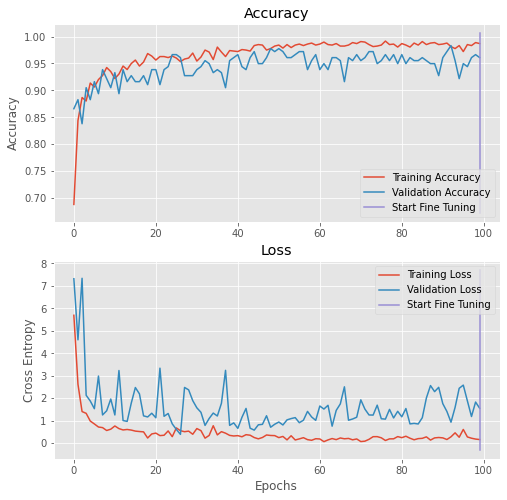

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 3.3185 - accuracy: 0.9062

2/5 [===========>..................] - ETA: 2s - loss: 1.6660 - accuracy: 0.9492

3/5 [=================>............] - ETA: 2s - loss: 1.1704 - accuracy: 0.9635

4/5 [=======================>......] - ETA: 1s - loss: 0.9816 - accuracy: 0.9707

5/5 [==============================] - ETA: 0s - loss: 0.9324 - accuracy: 0.9722

5/5 [==============================] - 9s 2s/step - loss: 0.9324 - accuracy: 0.9722


[0.9324330687522888, 0.9721707105636597]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

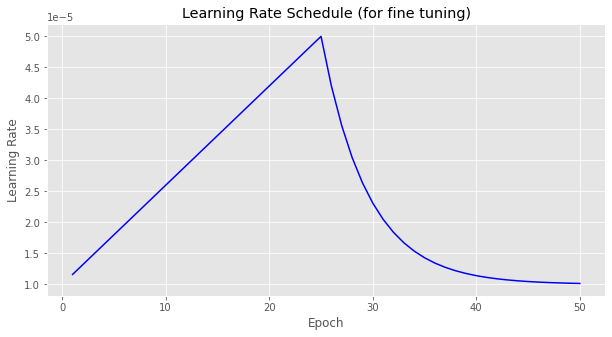

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 1077 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/17 [>.............................] - ETA: 0s - loss: 7.4506e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 4s - loss: 3.7253e-09 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 9s - loss: 8.0715e-09 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 9s - loss: 0.0306 - accuracy: 0.9961    

 5/17 [=======>......................] - ETA: 10s - loss: 0.1703 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 10s - loss: 0.1696 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 9s - loss: 0.1874 - accuracy: 0.9888 

 8/17 [=============>................] - ETA: 11s - loss: 0.1807 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 10s - loss: 0.1607 - accuracy: 0.9896

10/17 [================>.............] - ETA: 9s - loss: 0.1446 - accuracy: 0.9906 

11/17 [==================>...........] - ETA: 8s - loss: 0.1423 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 6s - loss: 0.1564 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1444 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1341 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1251 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1173 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1118 - accuracy: 0.9926

17/17 [==============================] - 22s 1s/step - loss: 0.1118 - accuracy: 0.9926 - val_loss: 1.5321 - val_accuracy: 0.9609



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 14s - loss: 8.4750e-08 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 13s - loss: 5.7121e-08 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 13s - loss: 5.3175e-07 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 16s - loss: 0.1639 - accuracy: 0.9937    

 6/17 [=========>....................] - ETA: 13s - loss: 0.1366 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 12s - loss: 0.1901 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.1670 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 11s - loss: 0.1485 - accuracy: 0.9948

10/17 [================>.............] - ETA: 9s - loss: 0.2310 - accuracy: 0.9937 

11/17 [==================>...........] - ETA: 8s - loss: 0.2526 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 6s - loss: 0.2485 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.2573 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.2389 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.2875 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2696 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.2671 - accuracy: 0.9870

17/17 [==============================] - 23s 1s/step - loss: 0.2671 - accuracy: 0.9870 - val_loss: 1.5189 - val_accuracy: 0.9665



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0139 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 8s - loss: 0.0070 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 7s - loss: 0.0051 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 7s - loss: 0.0038 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 13s - loss: 0.0793 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 10s - loss: 0.0815 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.0701 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.0860 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.1033 - accuracy: 0.9896

10/17 [================>.............] - ETA: 9s - loss: 0.0930 - accuracy: 0.9906 

11/17 [==================>...........] - ETA: 8s - loss: 0.0845 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 6s - loss: 0.0777 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.0717 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 3s - loss: 0.0775 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.0723 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.0782 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9926

17/17 [==============================] - 22s 1s/step - loss: 0.0744 - accuracy: 0.9926 - val_loss: 1.5319 - val_accuracy: 0.9665



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 6s - loss: 0.0291 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 14s - loss: 0.0297 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 12s - loss: 0.0222 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 14s - loss: 0.0657 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 12s - loss: 0.0940 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 11s - loss: 0.0816 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 11s - loss: 0.0974 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 10s - loss: 0.0865 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.2070 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 8s - loss: 0.1882 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1837 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1702 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.1580 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1528 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1433 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.9879

17/17 [==============================] - 22s 1s/step - loss: 0.1575 - accuracy: 0.9879 - val_loss: 1.5283 - val_accuracy: 0.9665



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2288 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 8s - loss: 0.1144 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 17s - loss: 0.0763 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 13s - loss: 0.0581 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 16s - loss: 0.0775 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 13s - loss: 0.0646 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 16s - loss: 0.1060 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 15s - loss: 0.0927 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 13s - loss: 0.0824 - accuracy: 0.9931

10/17 [================>.............] - ETA: 12s - loss: 0.1166 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1060 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.0972 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.0897 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.0833 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0777 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.1051 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1000 - accuracy: 0.9926

17/17 [==============================] - 24s 1s/step - loss: 0.1000 - accuracy: 0.9926 - val_loss: 1.5287 - val_accuracy: 0.9609



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/17 [>.............................] - ETA: 0s - loss: 1.8440e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.0600 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 14s - loss: 0.0400 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 14s - loss: 0.1788 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 14s - loss: 0.2003 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 16s - loss: 0.1669 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 15s - loss: 0.1431 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 14s - loss: 0.1252 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 13s - loss: 0.1258 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.1138 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.1111 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.1417 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1308 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 3s - loss: 0.1273 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1188 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1469 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1396 - accuracy: 0.9926

17/17 [==============================] - 23s 1s/step - loss: 0.1396 - accuracy: 0.9926 - val_loss: 1.5367 - val_accuracy: 0.9609



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/17 [>.............................] - ETA: 0s - loss: 1.7875e-04 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 15s - loss: 0.5173 - accuracy: 0.9844   

 3/17 [====>.........................] - ETA: 13s - loss: 0.4664 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 17s - loss: 0.4495 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 14s - loss: 0.3596 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 16s - loss: 0.3850 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 14s - loss: 0.3531 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 15s - loss: 0.4495 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 13s - loss: 0.3997 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.3597 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.3270 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.3270 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.3342 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.3103 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.3068 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2877 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.9879

17/17 [==============================] - 24s 1s/step - loss: 0.2736 - accuracy: 0.9879 - val_loss: 1.5217 - val_accuracy: 0.9665



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 13s - loss: 0.2297 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 13s - loss: 0.1532 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.1632 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 18s - loss: 0.1306 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.1088 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.0933 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.0816 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.1254 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.1129 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1026 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.0941 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.0868 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.0806 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0753 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.0706 - accuracy: 0.9941

17/17 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.9944

17/17 [==============================] - 23s 1s/step - loss: 0.0671 - accuracy: 0.9944 - val_loss: 1.5179 - val_accuracy: 0.9665



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/17 [>.............................] - ETA: 0s - loss: 8.8555e-04 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 8s - loss: 0.0420 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 22s - loss: 0.1346 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 21s - loss: 0.2678 - accuracy: 0.9688

 5/17 [=======>......................] - ETA: 17s - loss: 0.2718 - accuracy: 0.9688

 6/17 [=========>....................] - ETA: 15s - loss: 0.2265 - accuracy: 0.9740

 7/17 [===========>..................] - ETA: 13s - loss: 0.2126 - accuracy: 0.9754

 8/17 [=============>................] - ETA: 13s - loss: 0.1861 - accuracy: 0.9785

 9/17 [==============>...............] - ETA: 12s - loss: 0.1654 - accuracy: 0.9809

10/17 [================>.............] - ETA: 10s - loss: 0.1796 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 9s - loss: 0.2658 - accuracy: 0.9801 

12/17 [====================>.........] - ETA: 7s - loss: 0.2436 - accuracy: 0.9818

13/17 [=====================>........] - ETA: 5s - loss: 0.2400 - accuracy: 0.9820

14/17 [=======================>......] - ETA: 4s - loss: 0.2244 - accuracy: 0.9821

15/17 [=========================>....] - ETA: 2s - loss: 0.2477 - accuracy: 0.9802

16/17 [===========================>..] - ETA: 1s - loss: 0.2322 - accuracy: 0.9814

17/17 [==============================] - ETA: 0s - loss: 0.2208 - accuracy: 0.9824

17/17 [==============================] - 23s 1s/step - loss: 0.2208 - accuracy: 0.9824 - val_loss: 1.4894 - val_accuracy: 0.9665



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/17 [>.............................] - ETA: 0s - loss: 0.9604 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 3s - loss: 0.4829 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 18s - loss: 0.4410 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 14s - loss: 0.3307 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 11s - loss: 0.2646 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.2205 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 11s - loss: 0.1908 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 12s - loss: 0.1720 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.1529 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.1376 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 8s - loss: 0.1251 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.1147 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.1772 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 3s - loss: 0.2213 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.2066 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.2137 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.2058 - accuracy: 0.9898

17/17 [==============================] - 22s 1s/step - loss: 0.2058 - accuracy: 0.9898 - val_loss: 1.5066 - val_accuracy: 0.9665



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1855 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 6s - loss: 0.0928 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 13s - loss: 0.1427 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 18s - loss: 0.1072 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 14s - loss: 0.0858 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 13s - loss: 0.0912 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 16s - loss: 0.0781 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 15s - loss: 0.0684 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 13s - loss: 0.0608 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.0831 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.0757 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.0695 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.0647 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.0601 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.0634 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.0833 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.0792 - accuracy: 0.9907

17/17 [==============================] - 23s 1s/step - loss: 0.0792 - accuracy: 0.9907 - val_loss: 1.5443 - val_accuracy: 0.9609



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/17 [>.............................] - ETA: 0s - loss: 4.5416e-04 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 2.2708e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 17s - loss: 1.5139e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 19s - loss: 1.1354e-04 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 15s - loss: 0.0048 - accuracy: 0.9969    

 6/17 [=========>....................] - ETA: 16s - loss: 0.0040 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 15s - loss: 0.0155 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 14s - loss: 0.0135 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 13s - loss: 0.0120 - accuracy: 0.9965

10/17 [================>.............] - ETA: 10s - loss: 0.0108 - accuracy: 0.9969

11/17 [==================>...........] - ETA: 8s - loss: 0.0344 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.0315 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.0477 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 3s - loss: 0.0849 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0955 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.0895 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.0851 - accuracy: 0.9935

17/17 [==============================] - 23s 1s/step - loss: 0.0851 - accuracy: 0.9935 - val_loss: 1.5508 - val_accuracy: 0.9553



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/17 [>.............................] - ETA: 0s - loss: 9.3132e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 10s - loss: 5.5879e-09 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 16s - loss: 3.2409e-07 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 13s - loss: 2.4400e-07 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 16s - loss: 1.9520e-07 - accuracy: 1.0000

 6/17 [=========>....................] - ETA: 13s - loss: 0.0146 - accuracy: 0.9974    

 7/17 [===========>..................] - ETA: 13s - loss: 0.0761 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 12s - loss: 0.1286 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 10s - loss: 0.1143 - accuracy: 0.9948

10/17 [================>.............] - ETA: 9s - loss: 0.1029 - accuracy: 0.9953 

11/17 [==================>...........] - ETA: 8s - loss: 0.0936 - accuracy: 0.9957

12/17 [====================>.........] - ETA: 7s - loss: 0.0924 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.1167 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 3s - loss: 0.1124 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1546 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1736 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1653 - accuracy: 0.9907

17/17 [==============================] - 23s 1s/step - loss: 0.1653 - accuracy: 0.9907 - val_loss: 1.5480 - val_accuracy: 0.9609



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4680 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 12s - loss: 0.2340 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 10s - loss: 0.1560 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 11s - loss: 0.1170 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 12s - loss: 0.0940 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 10s - loss: 0.1562 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 14s - loss: 0.1339 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.1172 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.1041 - accuracy: 0.9948

10/17 [================>.............] - ETA: 9s - loss: 0.0937 - accuracy: 0.9953 

11/17 [==================>...........] - ETA: 8s - loss: 0.1786 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 6s - loss: 0.1637 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.1511 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 3s - loss: 0.1403 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.1435 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.1345 - accuracy: 0.9941

17/17 [==============================] - ETA: 0s - loss: 0.1279 - accuracy: 0.9944

17/17 [==============================] - 22s 1s/step - loss: 0.1279 - accuracy: 0.9944 - val_loss: 1.5270 - val_accuracy: 0.9609



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/17 [>.............................] - ETA: 0s - loss: 5.0693e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 21s - loss: 0.1051 - accuracy: 0.9844   

 3/17 [====>.........................] - ETA: 16s - loss: 0.3801 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 12s - loss: 0.2851 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 18s - loss: 0.4192 - accuracy: 0.9750

 6/17 [=========>....................] - ETA: 15s - loss: 0.3990 - accuracy: 0.9740

 7/17 [===========>..................] - ETA: 13s - loss: 0.3420 - accuracy: 0.9777

 8/17 [=============>................] - ETA: 12s - loss: 0.2992 - accuracy: 0.9805

 9/17 [==============>...............] - ETA: 10s - loss: 0.2660 - accuracy: 0.9826

10/17 [================>.............] - ETA: 9s - loss: 0.2394 - accuracy: 0.9844 

11/17 [==================>...........] - ETA: 8s - loss: 0.2317 - accuracy: 0.9830

12/17 [====================>.........] - ETA: 7s - loss: 0.2620 - accuracy: 0.9805

13/17 [=====================>........] - ETA: 5s - loss: 0.3268 - accuracy: 0.9796

14/17 [=======================>......] - ETA: 3s - loss: 0.3034 - accuracy: 0.9810

15/17 [=========================>....] - ETA: 2s - loss: 0.2980 - accuracy: 0.9812

16/17 [===========================>..] - ETA: 1s - loss: 0.3075 - accuracy: 0.9805

17/17 [==============================] - ETA: 0s - loss: 0.2949 - accuracy: 0.9805

17/17 [==============================] - 23s 1s/step - loss: 0.2949 - accuracy: 0.9805 - val_loss: 1.5034 - val_accuracy: 0.9609



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 8s - loss: 6.2717e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 19s - loss: 4.2681e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 16s - loss: 3.2011e-04 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 15s - loss: 0.0398 - accuracy: 0.9969    

 6/17 [=========>....................] - ETA: 14s - loss: 0.0753 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 13s - loss: 0.0646 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 13s - loss: 0.0565 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 12s - loss: 0.0667 - accuracy: 0.9948

10/17 [================>.............] - ETA: 11s - loss: 0.0600 - accuracy: 0.9953

11/17 [==================>...........] - ETA: 9s - loss: 0.0550 - accuracy: 0.9957 

12/17 [====================>.........] - ETA: 7s - loss: 0.0504 - accuracy: 0.9961

13/17 [=====================>........] - ETA: 5s - loss: 0.0649 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 4s - loss: 0.0603 - accuracy: 0.9955

15/17 [=========================>....] - ETA: 2s - loss: 0.0844 - accuracy: 0.9948

16/17 [===========================>..] - ETA: 1s - loss: 0.0806 - accuracy: 0.9941

17/17 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9944

17/17 [==============================] - 24s 1s/step - loss: 0.0767 - accuracy: 0.9944 - val_loss: 1.4864 - val_accuracy: 0.9609



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/17 [>.............................] - ETA: 0s - loss: 6.9103e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 0.0441 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 13s - loss: 0.2269 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 11s - loss: 0.2445 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 13s - loss: 0.2322 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.1935 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 12s - loss: 0.1658 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 12s - loss: 0.1451 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 11s - loss: 0.1449 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.1304 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.1185 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.1086 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.1665 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1546 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1443 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1629 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1548 - accuracy: 0.9916

17/17 [==============================] - 23s 1s/step - loss: 0.1548 - accuracy: 0.9916 - val_loss: 1.4875 - val_accuracy: 0.9609



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0309 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.0820 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 16s - loss: 0.1153 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 13s - loss: 0.0887 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 16s - loss: 0.0710 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.0592 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 14s - loss: 0.0513 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 12s - loss: 0.0478 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 10s - loss: 0.0430 - accuracy: 0.9931

10/17 [================>.............] - ETA: 9s - loss: 0.0387 - accuracy: 0.9937 

11/17 [==================>...........] - ETA: 7s - loss: 0.1374 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 6s - loss: 0.1336 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 4s - loss: 0.1384 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1285 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1272 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1300 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1383 - accuracy: 0.9898

17/17 [==============================] - 22s 1s/step - loss: 0.1383 - accuracy: 0.9898 - val_loss: 1.4874 - val_accuracy: 0.9609



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/17 [>.............................] - ETA: 0s - loss: 1.8626e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 1.1045e-06 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 7s - loss: 0.3259 - accuracy: 0.9948    

 4/17 [======>.......................] - ETA: 7s - loss: 0.3191 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 15s - loss: 0.2553 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 17s - loss: 0.2716 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 14s - loss: 0.2328 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.2068 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.1869 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.2063 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 8s - loss: 0.2032 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 6s - loss: 0.2251 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.2077 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.1929 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1950 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1828 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1970 - accuracy: 0.9889

17/17 [==============================] - 22s 1s/step - loss: 0.1970 - accuracy: 0.9889 - val_loss: 1.4881 - val_accuracy: 0.9609



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0546 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 5s - loss: 0.0468 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 6s - loss: 0.0547 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 11s - loss: 0.0778 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 13s - loss: 0.0623 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 12s - loss: 0.2377 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 10s - loss: 0.2061 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 11s - loss: 0.1803 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 9s - loss: 0.2139 - accuracy: 0.9826 

10/17 [================>.............] - ETA: 8s - loss: 0.1925 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 6s - loss: 0.1750 - accuracy: 0.9858

12/17 [====================>.........] - ETA: 5s - loss: 0.1604 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 4s - loss: 0.1481 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.1375 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1293 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1421 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9879

17/17 [==============================] - 21s 1s/step - loss: 0.1351 - accuracy: 0.9879 - val_loss: 1.5204 - val_accuracy: 0.9609



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 4.0884e-07 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 6s - loss: 2.7318e-07 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 12s - loss: 0.0100 - accuracy: 0.9961   

 5/17 [=======>......................] - ETA: 10s - loss: 0.0080 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 10s - loss: 0.0167 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 11s - loss: 0.0143 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 10s - loss: 0.0126 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 9s - loss: 0.1219 - accuracy: 0.9948 

10/17 [================>.............] - ETA: 8s - loss: 0.1097 - accuracy: 0.9953

11/17 [==================>...........] - ETA: 7s - loss: 0.1002 - accuracy: 0.9957

12/17 [====================>.........] - ETA: 5s - loss: 0.0919 - accuracy: 0.9961

13/17 [=====================>........] - ETA: 4s - loss: 0.1098 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 3s - loss: 0.1215 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.1329 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1726 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.9916

17/17 [==============================] - 21s 1s/step - loss: 0.1641 - accuracy: 0.9916 - val_loss: 1.5299 - val_accuracy: 0.9609



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4853 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 3s - loss: 0.3745 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 9s - loss: 0.2497 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 11s - loss: 0.1884 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 12s - loss: 0.1507 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.1256 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.1077 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 11s - loss: 0.0942 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 9s - loss: 0.1053 - accuracy: 0.9913 

10/17 [================>.............] - ETA: 8s - loss: 0.1107 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 7s - loss: 0.1213 - accuracy: 0.9886

12/17 [====================>.........] - ETA: 6s - loss: 0.1112 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 4s - loss: 0.1179 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.1095 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1022 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.0958 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.0913 - accuracy: 0.9916

17/17 [==============================] - 21s 1s/step - loss: 0.0913 - accuracy: 0.9916 - val_loss: 1.5581 - val_accuracy: 0.9609



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0634 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.0317 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 15s - loss: 0.0919 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 16s - loss: 0.0875 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 15s - loss: 0.0700 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 12s - loss: 0.0584 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 14s - loss: 0.0500 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 14s - loss: 0.0438 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.0389 - accuracy: 0.9948

10/17 [================>.............] - ETA: 10s - loss: 0.0705 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 8s - loss: 0.0641 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.0758 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.0713 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 3s - loss: 0.0662 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.1020 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.0956 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.0909 - accuracy: 0.9926

17/17 [==============================] - 23s 1s/step - loss: 0.0909 - accuracy: 0.9926 - val_loss: 1.5721 - val_accuracy: 0.9609



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/17 [>.............................] - ETA: 0s - loss: 2.2137e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.0387 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 9s - loss: 0.0258 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 13s - loss: 0.0194 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 14s - loss: 0.0471 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 12s - loss: 0.1157 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 12s - loss: 0.0992 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 12s - loss: 0.1200 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 11s - loss: 0.1066 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.0960 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 8s - loss: 0.0873 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 6s - loss: 0.1118 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1317 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.2374 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.2355 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.2207 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.2099 - accuracy: 0.9898

17/17 [==============================] - 22s 1s/step - loss: 0.2099 - accuracy: 0.9898 - val_loss: 1.5599 - val_accuracy: 0.9609



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/17 [>.............................] - ETA: 0s - loss: 7.9709e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 4.5470e-06 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 9s - loss: 3.7360e-06 - accuracy: 1.0000 

 4/17 [======>.......................] - ETA: 14s - loss: 2.8025e-06 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 14s - loss: 1.4567e-05 - accuracy: 1.0000

 6/17 [=========>....................] - ETA: 12s - loss: 1.2139e-05 - accuracy: 1.0000

 7/17 [===========>..................] - ETA: 12s - loss: 1.0414e-05 - accuracy: 1.0000

 8/17 [=============>................] - ETA: 12s - loss: 2.4351e-04 - accuracy: 1.0000

 9/17 [==============>...............] - ETA: 10s - loss: 2.1674e-04 - accuracy: 1.0000

10/17 [================>.............] - ETA: 9s - loss: 0.0296 - accuracy: 0.9969     

11/17 [==================>...........] - ETA: 7s - loss: 0.0549 - accuracy: 0.9957

12/17 [====================>.........] - ETA: 6s - loss: 0.0503 - accuracy: 0.9961

13/17 [=====================>........] - ETA: 5s - loss: 0.0481 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 3s - loss: 0.0835 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0780 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.0731 - accuracy: 0.9941

17/17 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 0.9935

17/17 [==============================] - 22s 1s/step - loss: 0.0756 - accuracy: 0.9935 - val_loss: 1.5532 - val_accuracy: 0.9609



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2267 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 3s - loss: 0.1134 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 17s - loss: 0.1067 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 17s - loss: 0.0800 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 16s - loss: 0.0642 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.0762 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 12s - loss: 0.0653 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 12s - loss: 0.1016 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.1472 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.1325 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 8s - loss: 0.1205 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1104 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1455 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.2405 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.2270 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2128 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.2024 - accuracy: 0.9879

17/17 [==============================] - 23s 1s/step - loss: 0.2024 - accuracy: 0.9879 - val_loss: 1.5297 - val_accuracy: 0.9609



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/17 [>.............................] - ETA: 0s - loss: 1.4003e-04 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 4s - loss: 7.0014e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 10s - loss: 4.7721e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 12s - loss: 0.0308 - accuracy: 0.9961    

 5/17 [=======>......................] - ETA: 14s - loss: 0.0564 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 13s - loss: 0.0470 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 11s - loss: 0.0403 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 12s - loss: 0.0353 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 11s - loss: 0.0313 - accuracy: 0.9965

10/17 [================>.............] - ETA: 9s - loss: 0.0282 - accuracy: 0.9969 

11/17 [==================>...........] - ETA: 7s - loss: 0.0268 - accuracy: 0.9972

12/17 [====================>.........] - ETA: 6s - loss: 0.0330 - accuracy: 0.9961

13/17 [=====================>........] - ETA: 5s - loss: 0.0304 - accuracy: 0.9964

14/17 [=======================>......] - ETA: 3s - loss: 0.0298 - accuracy: 0.9955

15/17 [=========================>....] - ETA: 2s - loss: 0.0278 - accuracy: 0.9958

16/17 [===========================>..] - ETA: 1s - loss: 0.0260 - accuracy: 0.9961

17/17 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9963

17/17 [==============================] - 22s 1s/step - loss: 0.0248 - accuracy: 0.9963 - val_loss: 1.5266 - val_accuracy: 0.9609



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 11s - loss: 0.1560 - accuracy: 0.9948   

 4/17 [======>.......................] - ETA: 11s - loss: 0.1559 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 15s - loss: 0.1280 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 16s - loss: 0.1067 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 15s - loss: 0.1311 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 14s - loss: 0.1147 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.1019 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.0917 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.1261 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1309 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1208 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1122 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1302 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1357 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 0.9907

17/17 [==============================] - 23s 1s/step - loss: 0.1290 - accuracy: 0.9907 - val_loss: 1.5375 - val_accuracy: 0.9609



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 0.0000e+00 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 24s - loss: 0.6320 - accuracy: 0.9896   

 4/17 [======>.......................] - ETA: 19s - loss: 0.4740 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 17s - loss: 0.4918 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.4099 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 16s - loss: 0.3517 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 15s - loss: 0.3328 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 13s - loss: 0.2958 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.2663 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.2421 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.2219 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.2048 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 4s - loss: 0.1902 - accuracy: 0.9955

15/17 [=========================>....] - ETA: 2s - loss: 0.1785 - accuracy: 0.9948

16/17 [===========================>..] - ETA: 1s - loss: 0.1911 - accuracy: 0.9941

17/17 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9944

17/17 [==============================] - 23s 1s/step - loss: 0.1817 - accuracy: 0.9944 - val_loss: 1.5426 - val_accuracy: 0.9609



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4343 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 9s - loss: 0.4778 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 8s - loss: 0.3186 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 9s - loss: 0.2389 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 15s - loss: 0.1911 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.2193 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 11s - loss: 0.1879 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 11s - loss: 0.2286 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 10s - loss: 0.2288 - accuracy: 0.9878

10/17 [================>.............] - ETA: 9s - loss: 0.2059 - accuracy: 0.9891 

11/17 [==================>...........] - ETA: 8s - loss: 0.2031 - accuracy: 0.9886

12/17 [====================>.........] - ETA: 6s - loss: 0.1862 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1719 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1779 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1661 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1741 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9879

17/17 [==============================] - 22s 1s/step - loss: 0.1752 - accuracy: 0.9879 - val_loss: 1.5463 - val_accuracy: 0.9609



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/17 [>.............................] - ETA: 0s - loss: 3.3265e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 0.0854 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 18s - loss: 0.0571 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 17s - loss: 0.0889 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 17s - loss: 0.0711 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 15s - loss: 0.1940 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.1711 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.1956 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 12s - loss: 0.1739 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.2316 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.2426 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.2224 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.2053 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1906 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1779 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1772 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1800 - accuracy: 0.9898

17/17 [==============================] - 24s 1s/step - loss: 0.1800 - accuracy: 0.9898 - val_loss: 1.5318 - val_accuracy: 0.9609



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150


 1/17 [>.............................] - ETA: 0s - loss: 3.2230e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 6s - loss: 0.3723 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 16s - loss: 0.2482 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 12s - loss: 0.1862 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 14s - loss: 0.2535 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 15s - loss: 0.2568 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 14s - loss: 0.2202 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 12s - loss: 0.1926 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 10s - loss: 0.1712 - accuracy: 0.9948

10/17 [================>.............] - ETA: 9s - loss: 0.2122 - accuracy: 0.9937 

11/17 [==================>...........] - ETA: 7s - loss: 0.2269 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 6s - loss: 0.2080 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 4s - loss: 0.1920 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 3s - loss: 0.1820 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.1698 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.1592 - accuracy: 0.9941

17/17 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9935

17/17 [==============================] - 22s 1s/step - loss: 0.1528 - accuracy: 0.9935 - val_loss: 1.5414 - val_accuracy: 0.9609



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 4s - loss: 2.7940e-09 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 16s - loss: 0.0269 - accuracy: 0.9948   

 4/17 [======>.......................] - ETA: 14s - loss: 0.0202 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 12s - loss: 0.0162 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 16s - loss: 0.0139 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 13s - loss: 0.0119 - accuracy: 0.9978

 8/17 [=============>................] - ETA: 12s - loss: 0.0104 - accuracy: 0.9980

 9/17 [==============>...............] - ETA: 10s - loss: 0.0500 - accuracy: 0.9948

10/17 [================>.............] - ETA: 8s - loss: 0.0450 - accuracy: 0.9953 

11/17 [==================>...........] - ETA: 7s - loss: 0.0409 - accuracy: 0.9957

12/17 [====================>.........] - ETA: 6s - loss: 0.0375 - accuracy: 0.9961

13/17 [=====================>........] - ETA: 5s - loss: 0.0346 - accuracy: 0.9964

14/17 [=======================>......] - ETA: 3s - loss: 0.0397 - accuracy: 0.9955

15/17 [=========================>....] - ETA: 2s - loss: 0.0871 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.0829 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.9926

17/17 [==============================] - 22s 1s/step - loss: 0.0914 - accuracy: 0.9926 - val_loss: 1.5498 - val_accuracy: 0.9609



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1136 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 13s - loss: 0.0568 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 14s - loss: 0.0528 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 15s - loss: 0.0445 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 16s - loss: 0.0356 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 18s - loss: 0.0297 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 16s - loss: 0.0255 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 15s - loss: 0.0867 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 13s - loss: 0.0771 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1471 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.1337 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1225 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1133 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1053 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.0983 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1088 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.9907

17/17 [==============================] - 23s 1s/step - loss: 0.1035 - accuracy: 0.9907 - val_loss: 1.5470 - val_accuracy: 0.9609



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/17 [>.............................] - ETA: 0s - loss: 2.1107e-04 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 1.0553e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 13s - loss: 7.0356e-05 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 13s - loss: 5.6273e-05 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 16s - loss: 4.2569e-04 - accuracy: 1.0000

 6/17 [=========>....................] - ETA: 13s - loss: 0.0827 - accuracy: 0.9948    

 7/17 [===========>..................] - ETA: 16s - loss: 0.1603 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 15s - loss: 0.1405 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 13s - loss: 0.1869 - accuracy: 0.9844

10/17 [================>.............] - ETA: 10s - loss: 0.1701 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 9s - loss: 0.1549 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.1420 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1582 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.1469 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.2423 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2690 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.9861

17/17 [==============================] - 23s 1s/step - loss: 0.2846 - accuracy: 0.9861 - val_loss: 1.5457 - val_accuracy: 0.9609



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/17 [>.............................] - ETA: 0s - loss: 1.1976e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 10s - loss: 6.0161e-07 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 21s - loss: 0.1791 - accuracy: 0.9948    

 4/17 [======>.......................] - ETA: 17s - loss: 0.1343 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 15s - loss: 0.1075 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 18s - loss: 0.0927 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 15s - loss: 0.0794 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 13s - loss: 0.0695 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 12s - loss: 0.0844 - accuracy: 0.9948

10/17 [================>.............] - ETA: 11s - loss: 0.0819 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.0747 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.0685 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.0632 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 4s - loss: 0.0735 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0686 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.0773 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9926

17/17 [==============================] - 24s 1s/step - loss: 0.0735 - accuracy: 0.9926 - val_loss: 1.5652 - val_accuracy: 0.9609



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 0.1422 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 15s - loss: 0.0948 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 24s - loss: 0.0711 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 19s - loss: 0.0569 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 16s - loss: 0.2313 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 16s - loss: 0.3284 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 15s - loss: 0.2873 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 13s - loss: 0.2554 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.2299 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 8s - loss: 0.2305 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.2116 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1954 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.4098 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.3825 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.3586 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.9907

17/17 [==============================] - 23s 1s/step - loss: 0.3410 - accuracy: 0.9907 - val_loss: 1.5874 - val_accuracy: 0.9609



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3042 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 12s - loss: 0.1521 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 21s - loss: 0.1365 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 16s - loss: 0.1024 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 18s - loss: 0.0820 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 18s - loss: 0.0683 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 16s - loss: 0.0586 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 15s - loss: 0.0717 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 13s - loss: 0.0728 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1209 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1155 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1319 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1629 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1513 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1567 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1610 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1531 - accuracy: 0.9898

17/17 [==============================] - 24s 1s/step - loss: 0.1531 - accuracy: 0.9898 - val_loss: 1.5655 - val_accuracy: 0.9609



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/17 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 0.1061 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 16s - loss: 0.0939 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 14s - loss: 0.0710 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 15s - loss: 0.0919 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.0766 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 17s - loss: 0.0884 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 15s - loss: 0.0774 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 13s - loss: 0.0688 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.0619 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.0873 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1588 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1466 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1361 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1271 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1191 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.1558 - accuracy: 0.9926

17/17 [==============================] - 24s 1s/step - loss: 0.1558 - accuracy: 0.9926 - val_loss: 1.5711 - val_accuracy: 0.9609



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/17 [>.............................] - ETA: 0s - loss: 5.4017e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 4s - loss: 4.9360e-08 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 20s - loss: 3.2907e-08 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 19s - loss: 0.0500 - accuracy: 0.9961    

 5/17 [=======>......................] - ETA: 15s - loss: 0.1877 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 14s - loss: 0.1564 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.1915 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 14s - loss: 0.2873 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 12s - loss: 0.2553 - accuracy: 0.9861

10/17 [================>.............] - ETA: 10s - loss: 0.3068 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.2789 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.2557 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.2360 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.2191 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.2045 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1917 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1823 - accuracy: 0.9916

17/17 [==============================] - 23s 1s/step - loss: 0.1823 - accuracy: 0.9916 - val_loss: 1.5563 - val_accuracy: 0.9609



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 24s - loss: 1.2107e-08 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 22s - loss: 1.0966e-05 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 17s - loss: 0.0349 - accuracy: 0.9961    

 5/17 [=======>......................] - ETA: 16s - loss: 0.0279 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 13s - loss: 0.0413 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 13s - loss: 0.0547 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 12s - loss: 0.0912 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 11s - loss: 0.0810 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.0729 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.0663 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.0608 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.0561 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 3s - loss: 0.1290 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.1378 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1452 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9926

17/17 [==============================] - 23s 1s/step - loss: 0.1380 - accuracy: 0.9926 - val_loss: 1.5491 - val_accuracy: 0.9609



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0315 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.0157 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 11s - loss: 0.1661 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 14s - loss: 0.1569 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 15s - loss: 0.1265 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 12s - loss: 0.1147 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 13s - loss: 0.1423 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 12s - loss: 0.1246 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 11s - loss: 0.1666 - accuracy: 0.9844

10/17 [================>.............] - ETA: 9s - loss: 0.1499 - accuracy: 0.9859 

11/17 [==================>...........] - ETA: 8s - loss: 0.1363 - accuracy: 0.9872

12/17 [====================>.........] - ETA: 6s - loss: 0.1852 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1951 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 3s - loss: 0.2130 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.2552 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.2392 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.2275 - accuracy: 0.9851

17/17 [==============================] - 22s 1s/step - loss: 0.2275 - accuracy: 0.9851 - val_loss: 1.5450 - val_accuracy: 0.9609



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/17 [>.............................] - ETA: 0s - loss: 5.5879e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.0446 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 13s - loss: 0.0721 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.2085 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 14s - loss: 0.1668 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 15s - loss: 0.1390 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 12s - loss: 0.1192 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 12s - loss: 0.1043 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.0927 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.1563 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1420 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1570 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1449 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1598 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1492 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1597 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9907

17/17 [==============================] - 23s 1s/step - loss: 0.1518 - accuracy: 0.9907 - val_loss: 1.5237 - val_accuracy: 0.9609



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0194 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 17s - loss: 0.3767 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 19s - loss: 0.2512 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 17s - loss: 0.3425 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 18s - loss: 0.2740 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.2372 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.2033 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.1779 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 10s - loss: 0.1582 - accuracy: 0.9931

10/17 [================>.............] - ETA: 9s - loss: 0.1423 - accuracy: 0.9937 

11/17 [==================>...........] - ETA: 7s - loss: 0.1880 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 6s - loss: 0.1723 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1634 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1557 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1610 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1509 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9907

17/17 [==============================] - 23s 1s/step - loss: 0.1435 - accuracy: 0.9907 - val_loss: 1.5026 - val_accuracy: 0.9609



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0777 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 10s - loss: 0.0550 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 17s - loss: 0.0367 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.0275 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 14s - loss: 0.0302 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.0252 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 16s - loss: 0.0216 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 14s - loss: 0.0627 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 13s - loss: 0.0558 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.0502 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.0456 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.0459 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.0431 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 3s - loss: 0.0400 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.0373 - accuracy: 0.9948

16/17 [===========================>..] - ETA: 1s - loss: 0.0350 - accuracy: 0.9951

17/17 [==============================] - ETA: 0s - loss: 0.0554 - accuracy: 0.9944

17/17 [==============================] - 23s 1s/step - loss: 0.0554 - accuracy: 0.9944 - val_loss: 1.4776 - val_accuracy: 0.9609



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2578 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 4s - loss: 0.1289 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 16s - loss: 0.1556 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 16s - loss: 0.1413 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 14s - loss: 0.1130 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 13s - loss: 0.0942 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 12s - loss: 0.2298 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 12s - loss: 0.2011 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 11s - loss: 0.1788 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.1609 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1463 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1341 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1384 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 3s - loss: 0.1285 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1199 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1124 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.1133 - accuracy: 0.9926

17/17 [==============================] - 23s 1s/step - loss: 0.1133 - accuracy: 0.9926 - val_loss: 1.4816 - val_accuracy: 0.9609



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1647 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 8s - loss: 0.1475 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 11s - loss: 0.0983 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 9s - loss: 0.0737 - accuracy: 0.9922 

 5/17 [=======>......................] - ETA: 14s - loss: 0.0590 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 12s - loss: 0.0492 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 14s - loss: 0.0421 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 13s - loss: 0.0524 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.2805 - accuracy: 0.9826

10/17 [================>.............] - ETA: 10s - loss: 0.2525 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 8s - loss: 0.2297 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 6s - loss: 0.2109 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1947 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.1808 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1687 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1582 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1505 - accuracy: 0.9907

17/17 [==============================] - 22s 1s/step - loss: 0.1505 - accuracy: 0.9907 - val_loss: 1.4667 - val_accuracy: 0.9609



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 8s - loss: 0.0246 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 16s - loss: 0.0167 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 17s - loss: 0.0125 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 18s - loss: 0.0100 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 16s - loss: 0.0083 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 16s - loss: 0.0242 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 15s - loss: 0.0377 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 13s - loss: 0.0360 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.0324 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.0294 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.0270 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.0249 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 4s - loss: 0.0488 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.0944 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.1026 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.1086 - accuracy: 0.9916

17/17 [==============================] - 24s 1s/step - loss: 0.1086 - accuracy: 0.9916 - val_loss: 1.4471 - val_accuracy: 0.9609



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0846 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.0423 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 11s - loss: 0.0401 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 19s - loss: 0.0301 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 17s - loss: 0.0241 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 16s - loss: 0.0201 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 15s - loss: 0.0172 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 14s - loss: 0.0151 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 12s - loss: 0.0134 - accuracy: 0.9965

10/17 [================>.............] - ETA: 10s - loss: 0.0121 - accuracy: 0.9969

11/17 [==================>...........] - ETA: 8s - loss: 0.0110 - accuracy: 0.9972 

12/17 [====================>.........] - ETA: 7s - loss: 0.0100 - accuracy: 0.9974

13/17 [=====================>........] - ETA: 5s - loss: 0.0093 - accuracy: 0.9976

14/17 [=======================>......] - ETA: 3s - loss: 0.0264 - accuracy: 0.9967

15/17 [=========================>....] - ETA: 2s - loss: 0.0446 - accuracy: 0.9958

16/17 [===========================>..] - ETA: 1s - loss: 0.0476 - accuracy: 0.9951

17/17 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.9944

17/17 [==============================] - 22s 1s/step - loss: 0.0592 - accuracy: 0.9944 - val_loss: 1.4300 - val_accuracy: 0.9609



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 17s - loss: 0.1186 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.0895 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 16s - loss: 0.0716 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 13s - loss: 0.0596 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 12s - loss: 0.0527 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 12s - loss: 0.0461 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 10s - loss: 0.0410 - accuracy: 0.9965

10/17 [================>.............] - ETA: 8s - loss: 0.0369 - accuracy: 0.9969 

11/17 [==================>...........] - ETA: 7s - loss: 0.0335 - accuracy: 0.9972

12/17 [====================>.........] - ETA: 6s - loss: 0.0906 - accuracy: 0.9961

13/17 [=====================>........] - ETA: 4s - loss: 0.0836 - accuracy: 0.9964

14/17 [=======================>......] - ETA: 3s - loss: 0.0813 - accuracy: 0.9955

15/17 [=========================>....] - ETA: 2s - loss: 0.0759 - accuracy: 0.9958

16/17 [===========================>..] - ETA: 1s - loss: 0.1444 - accuracy: 0.9951

17/17 [==============================] - ETA: 0s - loss: 0.1373 - accuracy: 0.9954

17/17 [==============================] - 22s 1s/step - loss: 0.1373 - accuracy: 0.9954 - val_loss: 1.4256 - val_accuracy: 0.9609


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

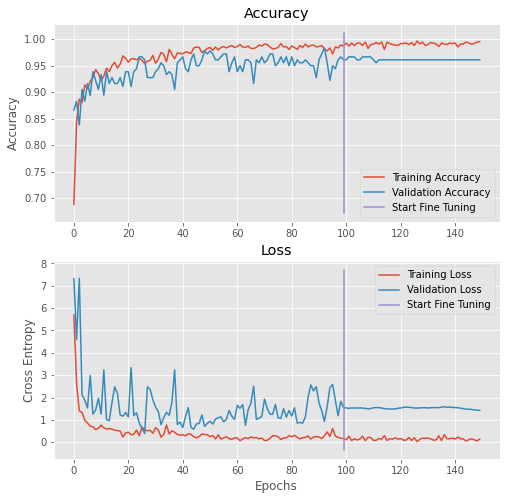

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 2.8890 - accuracy: 0.9219

2/5 [===========>..................] - ETA: 2s - loss: 1.4469 - accuracy: 0.9609

3/5 [=================>............] - ETA: 2s - loss: 1.0228 - accuracy: 0.9714

4/5 [=======================>......] - ETA: 1s - loss: 0.8658 - accuracy: 0.9766

5/5 [==============================] - ETA: 0s - loss: 0.8225 - accuracy: 0.9777

5/5 [==============================] - 6s 1s/step - loss: 0.8225 - accuracy: 0.9777


[0.822475790977478, 0.9777365326881409]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9777365491651205
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       158
           1       0.97      0.99      0.98       381

    accuracy                           0.98       539
   macro avg       0.98      0.97      0.97       539
weighted avg       0.98      0.98      0.98       539



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

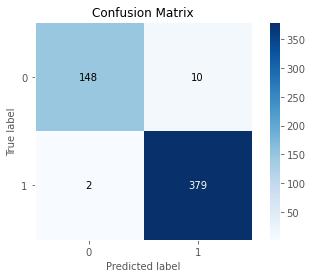

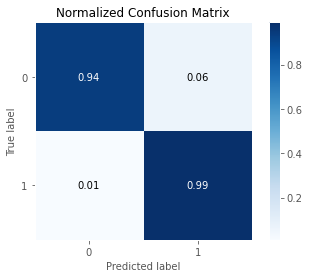

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

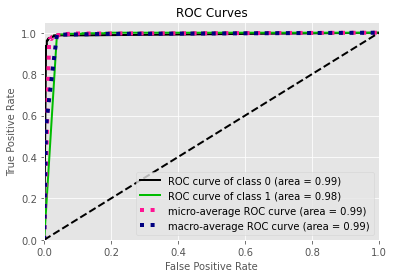

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       158
           1       0.97      0.99      0.98       381

    accuracy                           0.98       539
   macro avg       0.98      0.97      0.97       539
weighted avg       0.98      0.98      0.98       539

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.94      0.99      0.96      0.97      0.93       158
          1       0.97      0.99      0.94      0.98      0.97      0.94       381

avg / total       0.98      0.98      0.95      0.98      0.97      0.93       539

